# Análise Preditiva de Rotatividade de Clientes: Otimização e Avaliação de Modelos de Machine Learning

Este relatório detalha o processo de desenvolvimento e avaliação de modelos preditivos destinados a identificar clientes com risco de rotatividade (churn). A análise empregou uma metodologia rigorosa de machine learning, abrangendo desde o pré-processamento de dados heterogêneos até a otimização de hiperparâmetros e a avaliação multifacetada do desempenho do modelo. Foram utilizados dados históricos de clientes para treinar e validar dois algoritmos de ensemble robustos: Random Forest e Gradient Boosting. A pipeline de desenvolvimento incluiu etapas cruciais como codificação da variável target, One-Hot Encoding para variáveis categóricas, normalização para variáveis numéricas e, notavelmente, o balanceamento de classes com SMOTE aplicado exclusivamente ao conjunto de treino para mitigar o viés de dados desequilibrados e prevenir a contaminação de dados. A otimização de hiperparâmetros foi realizada via GridSearchCV com validação cruzada de 5 folds, utilizando a Área Sob a Curva (AUC) como métrica principal para garantir a capacidade discriminativa dos modelos. Os resultados comparativos dos modelos Random Forest e Gradient Boosting são apresentados através de relatórios de classificação, matrizes de confusão e curvas ROC, fornecendo uma avaliação abrangente que permite uma compreensão aprofundada da capacidade de cada modelo em prever a rotatividade de clientes de forma precisa e acionável.

# 1. Importando as Ferrementas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, auc)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import warnings
warnings.filterwarnings('ignore')

# 2. Carregamento e Exploração Inicial dos Dados



O conjunto de dados, fornecido no formato dados_df.csv , contém uma variedade de informações sobre clientes, que incluem características demográficas, detalhes de serviço e informações de cobrança. Uma inspeção inicial do arquivo revela uma diversidade de tipos de dados nas colunas.

In [2]:
# 2.1 Carregar os dados e identificar tipos de colunas
df = pd.read_csv('dados_df.csv')

#### 2.1.2 O código começa carregando o dataset e examinando sua estrutura

Essa heterogeneidade nos tipos de dados do conjunto de dados é uma observação fundamental que impõe a necessidade de uma estratégia de pré-processamento multifacetada. Não seria eficaz aplicar uma única transformação uniforme a todas as colunas, pois isso poderia distorcer ou invalidar as informações contidas em certas variáveis. Por exemplo, aplicar a normalização numérica a uma coluna binária seria desnecessário e potencialmente prejudicial. Em vez disso, a natureza intrínseca de cada coluna dita a aplicação de métodos de pré-processamento distintos. Variáveis verdadeiramente categóricas, sejam elas nominais ou ordinais, exigem técnicas de codificação específicas, enquanto variáveis numéricas se beneficiam de métodos de escalonamento para padronizar suas escalas. Essa abordagem adaptada ao tipo de dado de cada recurso é essencial para garantir que o modelo de machine learning possa interpretar e aprender efetivamente com a totalidade das informações disponíveis.

In [3]:
# 2.1.2 Verificar a estrutura dos dados
print("Dimensões do dataset:", df.shape)
print("\nPrimeiras linhas:\n", df.head())
print("\nInformações do dataset:")
df.info()

Dimensões do dataset: (7032, 25)

Primeiras linhas:
    Idoso  Parceiro  Dependentes  Estágio  Serviço Telefônico  Várias Linhas  \
0      0         1            1        9                   1              0   
1      0         0            0        9                   1              1   
2      0         0            0        4                   1              0   
3      1         1            0       13                   1              0   
4      1         1            0        3                   1              0   

   Segurança Online  OnlineBackup  Proteção do Dispositivo  Suporte Técnico  \
0                 0             1                        0                1   
1                 0             0                        0                0   
2                 0             0                        1                0   
3                 0             1                        1                0   
4                 0             0                        0                1  

#### 2.1.2.3 Identifica automaticamente as colunas numéricas, categóricas e a variável alvo
#### 2.1.2.3 Verifica a distribuição da variável alvo para entender o desbalanceamento

In [4]:
# 2.1.2.3 Identificar colunas
target = 'Rotatividade'
numeric_cols = ['Estágio', 'Charges.Monthly', 'Charges.Total', 'Conta_Cobrança.Diária']
categorical_cols = [col for col in df.columns if col not in numeric_cols + [target]]

print("\nColunas numéricas:", numeric_cols)
print("Colunas categóricas:", categorical_cols)
print("Variável alvo:", target)


Colunas numéricas: ['Estágio', 'Charges.Monthly', 'Charges.Total', 'Conta_Cobrança.Diária']
Colunas categóricas: ['Idoso', 'Parceiro', 'Dependentes', 'Serviço Telefônico', 'Várias Linhas', 'Segurança Online', 'OnlineBackup', 'Proteção do Dispositivo', 'Suporte Técnico', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Sexo_Masculino', 'Serviço de Internet_Fibra Óptica', 'Nº_Serviço de Internet', 'Contrato_Um Ano', 'Contrato_Dois Anos', 'Forma de Pagamento_Cartão de Crédito (Automático)', 'Forma de Pagamento_Cheque Eletrônico', 'Forma de Pagamento_Cheque Enviado pelo Correio']
Variável alvo: Rotatividade


# 3.Pré-processamento

#### 3.1 Converte a variável alvo para inteiro (garantindo formato binário)

#### 3.1 Cria pipelines de transformação:



A constatação de que a variável target já está codificada no formato binário (0/1) simplifica significativamente a pipeline de machine learning. Isso elimina a necessidade de uma etapa de codificação explícita para a variável dependente, como a aplicação de um Label Encoder. A ausência dessa etapa adicional não apenas otimiza o fluxo de trabalho, mas também reduz a margem para erros que poderiam ser introduzidos durante uma transformação manual ou automatizada da variável target. Assim, o modelo de classificação binária pode ser construído e treinado diretamente com a variável 'Rotatividade' em seu estado atual, contribuindo para uma pipeline mais limpa e eficiente.

In [5]:
# 3.1. Pré-processamento da variável alvo e variáveis categóricas
# 3.1 Verificar a distribuição da variável alvo
print("\nDistribuição da variável alvo:")
print(df[target].value_counts(normalize=True))

# 3.1. Converter para binário se necessário (garantir que é 0/1)
df[target] = df[target].astype(int)


Distribuição da variável alvo:
Rotatividade
0.0    0.734215
1.0    0.265785
Name: proportion, dtype: float64


Para as variáveis categóricas nominais presentes no dataset, foi aplicada a técnica de One-Hot Encoding. Esse método é crucial para converter dados categóricos não-ordinais em um formato numérico que os algoritmos de machine learning podem processar sem inferir uma ordem arbitrária entre as categorias. O One-Hot Encoding cria novas colunas binárias para cada categoria única em uma variável original: um valor de 1 indica a presença daquela categoria, e 0 indica sua ausência.

# 4. Encoding

#### 4.1 One-Hot Encoding para features categóricas
Para as variáveis categóricas nominais presentes no dataset, foi aplicada a técnica de One-Hot Encoding. Esse método é crucial para converter dados categóricos não-ordinais em um formato numérico que os algoritmos de machine learning podem processar sem inferir uma ordem arbitrária entre as categorias. O One-Hot Encoding cria novas colunas binárias para cada categoria única em uma variável original: um valor de 1 indica a presença daquela categoria, e 0 indica sua ausência.

#### 4.1 Normalização (StandardScaler) para features numéricas
As variáveis numéricas no conjunto de dados foram submetidas a um processo de normalização utilizando o StandardScaler da biblioteca scikit-learn. O StandardScaler padroniza as features removendo a média e escalando para a variância unitária, transformando os dados de forma que tenham uma média de 0 e um desvio padrão de 1. A fórmula para essa transformação é z = (x - u) / s, onde x é o valor original, u é a média das amostras de treino e s é o desvio padrão das amostras de treino.

In [6]:
# 4.1 Normalização das colunas numéricas e One-Hot Encoding para categóricas
# 4.1 Criar transformadores
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# 4.1 Combinar transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

#### 4.2 Divide os dados em conjuntos de treino e teste (70/30) mantendo a proporção das classes

Durante a aplicação do One-Hot Encoding, é uma prática recomendada utilizar o parâmetro drop_first=True. Isso significa que, para uma variável categórica com n categorias, em vez de criar n novas colunas binárias, apenas n-1 colunas são geradas. Por exemplo, se uma coluna de gênero tem "Masculino" e "Feminino", ao invés de criar Genero_Masculino e Genero_Feminino, apenas uma delas (e.g., Genero_Masculino) é mantida. Se Genero_Masculino for 1, o cliente é masculino; se for 0, o cliente é feminino. Essa abordagem é fundamental para mitigar a multicolinearidade, um fenômeno onde uma variável pode ser perfeitamente predita por uma combinação linear de outras variáveis. Embora algoritmos baseados em árvore, como Random Forest e Gradient Boosting, sejam geralmente menos sensíveis à multicolinearidade do que modelos lineares, a remoção dessa redundância contribui para uma representação de dados mais parcimoniosa e pode, em certos contextos, levar a uma maior estabilidade do modelo. Essa escolha metodológica reflete um entendimento aprofundado das implicações estatísticas da engenharia de features, resultando em uma entrada de dados mais limpa para os modelos.

In [7]:
# 4.2 Dividir os dados em treino e teste
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

print("\nDistribuição das classes no conjunto de treino:")
print(y_train.value_counts(normalize=True))
print("\nDistribuição das classes no conjunto de teste:")
print(y_test.value_counts(normalize=True))


Distribuição das classes no conjunto de treino:
Rotatividade
0    0.734254
1    0.265746
Name: proportion, dtype: float64

Distribuição das classes no conjunto de teste:
Rotatividade
0    0.734123
1    0.265877
Name: proportion, dtype: float64


# 5. Balanceamento com SMOTE

#### 5.1 Aplica SMOTE apenas no conjunto de treino para evitar vazamento de dados
Após o pré-processamento dos dados, as próximas etapas cruciais são a divisão do conjunto de dados e o tratamento do desequilíbrio de classes, ambos fundamentais para a construção de modelos preditivos confiáveis e justos.

#### 5.1 Gera amostras sintéticas da classe minoritária para balancear o treinamento
O problema do desequilíbrio de classes ocorre quando uma classe (minoritária) tem significativamente menos amostras que outra (majoritária). Em previsão de rotatividade, por exemplo, a classe "cancelou" (1) geralmente é a minoritária, enquanto "não cancelou" (0) é a majoritária. Esse desequilíbrio pode enviesar o modelo a favorecer a classe dominante, prejudicando sua capacidade de identificar casos raros.

Solução com SMOTE: Para equilibrar os dados, utilizamos a técnica SMOTE (Synthetic Minority Over-sampling Technique), que gera amostras sintéticas da classe minoritária interpolando entre exemplos reais e seus vizinhos mais próximos.

Prevenção de data leakage: O SMOTE foi aplicado apenas no conjunto de treino, evitando que informações do conjunto de teste influenciem a geração de amostras sintéticas. Se aplicado antes da divisão treino-teste, o modelo poderia ser avaliado em dados "vazados", levando a métricas infladas e uma falsa sensação de desempenho. Essa abordagem garante que a avaliação do modelo reflita sua real capacidade de generalização.

In [8]:
# 5.1 Aplicar SMOTE apenas no treino
smote = SMOTE(random_state=42)


# 6. Modelagem e Otimização

#### 6.1 Define dois modelos avançados:
A otimização de hiperparâmetros é uma etapa essencial no desenvolvimento de modelos de machine learning, pois permite ajustar as configurações internas de um algoritmo para maximizar seu desempenho. Sem essa etapa, um modelo pode facilmente subajustar (underfit) ou superajustar (overfit) os dados, comprometendo sua capacidade de generalização

#### 6.1.2 Random Forest
Random Forest é um algoritmo de ensemble que constrói múltiplas árvores de decisão durante o treino e produz a classe que é a moda das classes (para classificação) ou a média das previsões (para regressão) das árvores individuais. Sua performance é altamente dependente da escolha de seus hiperparâmetros. Para este estudo, os seguintes hiperparâmetros foram otimizados:   

- n_estimators: O número de árvores na floresta. Um valor maior geralmente melhora o desempenho, mas aumenta o tempo de computação.

- max_depth: A profundidade máxima de cada árvore de decisão. Controla a complexidade da árvore.

- min_samples_split: O número mínimo de amostras necessárias para dividir um nó interno.

- min_samples_leaf: O número mínimo de amostras necessárias para estar em um nó folha.

- max_features: O número de features a considerar para a melhor divisão em cada nó.

- criterion: A função para medir a qualidade de uma divisão (e.g., 'gini' para impureza de Gini ou 'entropy' para ganho de informação).   

- random_state: Controla a aleatoriedade do processo de treino para reprodutibilidade.

#### 6.1.2.3 Gradient Boosting
Gradient Boosting é outro poderoso algoritmo de ensemble que constrói árvores de decisão sequencialmente, onde cada nova árvore tenta corrigir os erros das árvores anteriores. A otimização de seus hiperparâmetros é igualmente importante. Os parâmetros otimizados para este modelo incluíram:   

- n_estimators: O número de estágios de boosting a serem realizados.

- learning_rate: Contribuição de cada árvore para o resultado final. Um valor menor requer mais n_estimators.

- max_depth: A profundidade máxima das árvores individuais.

- subsample: A fração de amostras a serem usadas para ajustar as árvores individuais.

- max_features: O número de features a considerar para a melhor divisão em cada nó.

  
#### 6.1.2.3.4 Configura GridSearchCV para cada modelo com diferentes hiperparâmetros
Para a otimização dos hiperparâmetros, foi empregada a metodologia GridSearchCV. O GridSearchCV é uma técnica de busca exaustiva que explora sistematicamente todas as combinações possíveis de hiperparâmetros definidos em uma grade. Para cada combinação, o modelo é treinado e avaliado, e a melhor combinação é retida com base em uma métrica de desempenho pré-definida.

#### 6.1.2.3.4.5 Usa validação cruzada (5 folds) e AUC como métrica de avaliação
A robustez da avaliação de cada combinação de hiperparâmetros é garantida pela integração da validação cruzada K-fold, especificamente com 5 folds, conforme o requisito. Nesse processo, o conjunto de treino é dividido em K (neste caso, 5) subconjuntos ou "folds". Em cada iteração, K-1 folds são usados para treinar o modelo, e o fold restante é usado para validação. Esse procedimento é repetido K vezes, garantindo que cada fold sirva uma vez como conjunto de validação. O desempenho de cada combinação de hiperparâmetros é então a média dos resultados obtidos em todas as iterações.

In [9]:
from imblearn.pipeline import Pipeline as imbPipeline

# 6.1 Inicializar dicionários para armazenar os resultados
best_models = {}  # Armazenará os melhores modelos
results = {}      # Armazenará os parâmetros e scores

# 6.1.2 Definir modelos com prefixos corretos
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'randomforest__n_estimators': [100, 200],
            'randomforest__max_depth': [None, 10, 20],
            'randomforest__min_samples_split': [2, 5],
            'randomforest__class_weight': ['balanced', None]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'gradientboosting__n_estimators': [100, 200],
            'gradientboosting__learning_rate': [0.05, 0.1],
            'gradientboosting__max_depth': [3, 5],
            'gradientboosting__min_samples_split': [2, 5]
        }
    }
}

for model_name, model_info in models.items():
    print(f"\nTreinando e otimizando {model_name}...")
    
    # 6.1.2.3 Criar pipeline com nome explícito para o classificador
    pipeline = imbPipeline([
        ('preprocessor', preprocessor),
        ('smote', smote),
        (model_name.lower(), model_info['model'])  # Nome do passo igual ao nome do modelo
    ])
    
    # 6.1.2.3.4 GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grid=model_info['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)

    
    
    # 6.1.2.3.4.5 Armazenar resultados
    best_models[model_name] = grid_search.best_estimator_
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }
    
    print(f"Melhores parâmetros para {model_name}:")
    print(grid_search.best_params_)
    print(f"Melhor AUC (validação cruzada): {grid_search.best_score_:.4f}")



Treinando e otimizando RandomForest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Melhores parâmetros para RandomForest:
{'randomforest__class_weight': 'balanced', 'randomforest__max_depth': 10, 'randomforest__min_samples_split': 2, 'randomforest__n_estimators': 200}
Melhor AUC (validação cruzada): 0.8390

Treinando e otimizando GradientBoosting...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Melhores parâmetros para GradientBoosting:
{'gradientboosting__learning_rate': 0.1, 'gradientboosting__max_depth': 3, 'gradientboosting__min_samples_split': 2, 'gradientboosting__n_estimators': 100}
Melhor AUC (validação cruzada): 0.8438


# 7. Avaliação dos Modelos

#### 7.1 Gera relatórios completos para cada modelo:
A avaliação do desempenho dos modelos é uma etapa crucial para compreender sua eficácia e identificar qual deles é mais adequado para o problema de previsão de rotatividade. Essa avaliação foi realizada no conjunto de teste, que, como discutido, permaneceu intocado durante o treino e o balanceamento de classes, garantindo uma medida imparcial da capacidade de generalização dos modelos.

#### 7.1.2 Matrizes de confusão
As matrizes de confusão fornecem uma visão granular do desempenho do modelo, detalhando as contagens de True Positives (TP), True Negatives (TN), False Positives (FP) e False Negatives (FN).

- Verdadeiros Positivos (TP): Clientes que realmente cancelaram e foram corretamente previstos como canceladores.

- Verdadeiros Negativos (TN): Clientes que não cancelaram e foram corretamente previstos como não canceladores.

- Falsos Positivos (FP): Clientes que não cancelaram, mas foram erroneamente previstos como canceladores (custo de intervenção desnecessária, como ofertas de retenção para clientes que não iriam sair).

- Falsos Negativos (FN): Clientes que cancelaram, mas foram erroneamente previstos como não canceladores (custo da perda de um cliente que poderia ter sido retido).

#### 7.1.2.3 Relatórios de classificação (precisão, recall, F1-score)
Para cada modelo (Random Forest e Gradient Boosting), foi gerado um relatório de classificação detalhado, fornecendo as métricas de Precisão, Recall e F1-score para ambas as classes (0: não rotatividade, 1: rotatividade).

- Precisão (Precision): Mede a proporção de instâncias positivas corretamente previstas entre todas as instâncias que o modelo classificou como positivas. Uma alta precisão para a classe de rotatividade (1) indica que, quando o modelo prevê que um cliente vai cancelar, é muito provável que essa previsão esteja correta, minimizando intervenções desnecessárias.

- Recall: Mede a proporção de instâncias positivas corretamente previstas entre todas as instâncias que são realmente positivas. Um alto recall para a classe de rotatividade (1) significa que o modelo é eficaz em identificar a maioria dos clientes que realmente vão cancelar, minimizando as perdas de clientes.

- F1-score: É a média harmônica da Precisão e do Recall. Ele fornece um equilíbrio entre as duas métricas, sendo particularmente útil em conjuntos de dados desequilibrados, onde uma alta precisão pode ser acompanhada por um baixo recall, ou vice-versa. O F1-score é uma métrica mais robusta para avaliar o desempenho geral em tais cenários.

#### 7.1.2.3.4 Curvas ROC e valores AUC
Além da visualização da curva ROC, o valor numérico da AUC (Área Sob a Curva) foi calculado para cada modelo. A AUC representa a probabilidade de que o modelo classificará aleatoriamente uma instância positiva mais alta do que uma instância negativa. Um valor de AUC mais próximo de 1.0 indica uma maior capacidade discriminativa do modelo. A comparação dos valores de AUC entre Random Forest e Gradient Boosting permite determinar qual modelo apresenta um desempenho superior na distinção entre clientes que cancelarão e os que não cancelarão.

A estratégia de avaliação multifacetada, que inclui AUC, Precisão, Recall, F1-score, Matrizes de Confusão e Curvas ROC, oferece uma compreensão completa e acionável do desempenho do modelo. Enquanto a AUC é uma excelente medida geral do poder discriminativo e é adequada para otimização, ela não fornece o panorama completo do desempenho do modelo, especialmente em um contexto de negócios.

#### 7.1.2.3.4.5 Compara visualmente o desempenho dos modelos
As curvas ROC (Receiver Operating Characteristic) dos modelos Random Forest e Gradient Boosting foram plotadas no mesmo gráfico para uma comparação visual direta. Uma curva ROC ilustra a capacidade discriminativa de um classificador binário ao traçar a Taxa de Verdadeiros Positivos (TPR - Recall) versus a Taxa de Falsos Positivos (FPR) em vários limiares de classificação. Quanto mais a curva se aproxima do canto superior esquerdo do gráfico, melhor é o desempenho do modelo em distinguir entre as classes.


Resultados para RandomForest no conjunto de teste:
AUC: 0.8387

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1549
           1       0.55      0.69      0.61       561

    accuracy                           0.77      2110
   macro avg       0.71      0.74      0.72      2110
weighted avg       0.79      0.77      0.77      2110


Matriz de confusão:
[[1230  319]
 [ 175  386]]


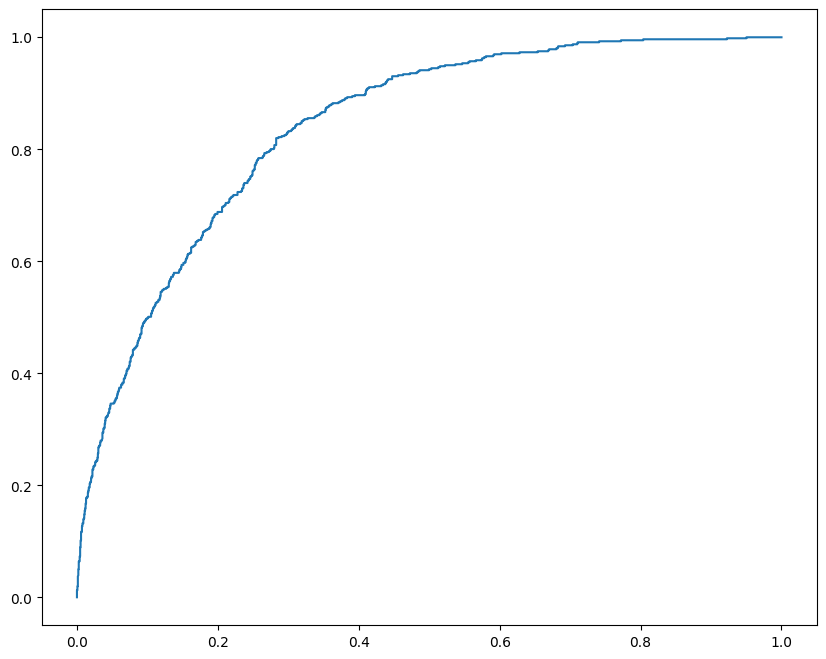

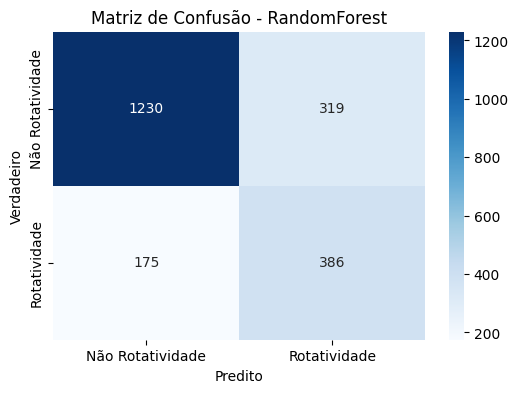


Resultados para GradientBoosting no conjunto de teste:
AUC: 0.8428

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1549
           1       0.57      0.67      0.62       561

    accuracy                           0.78      2110
   macro avg       0.72      0.74      0.73      2110
weighted avg       0.79      0.78      0.78      2110


Matriz de confusão:
[[1259  290]
 [ 183  378]]


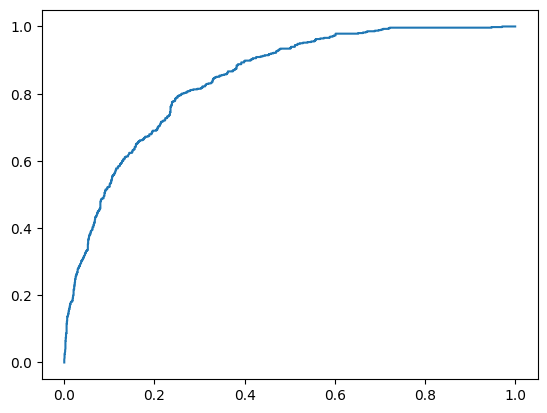

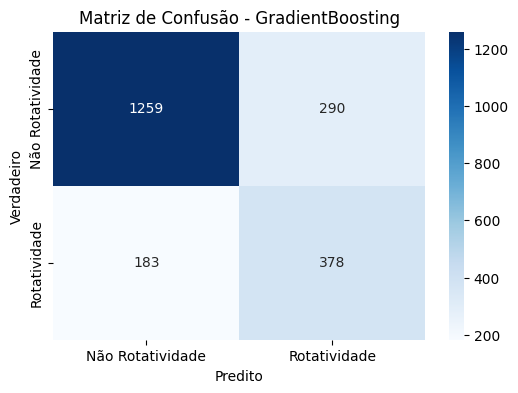

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


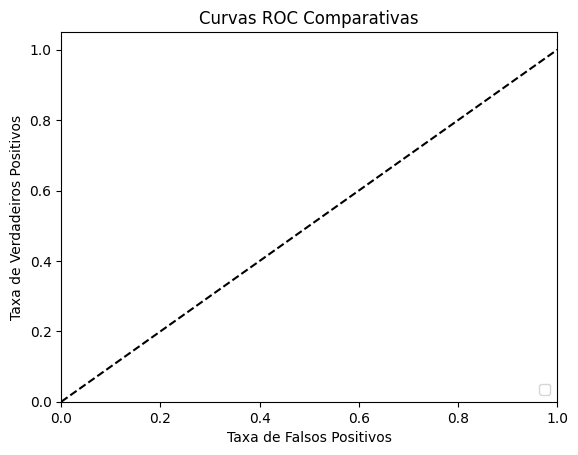

In [10]:
# 7.1 Avaliar os modelos no conjunto de teste
plt.figure(figsize=(10, 8))

for model_name, model in best_models.items():
    
    #7.1.2 Previsões
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # 7.1.2.3 Métricas
    auc_score = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # 7.1.2.3.4 Armazenar resultados
    results[model_name]['test_auc'] = auc_score
    results[model_name]['classification_report'] = report
    results[model_name]['confusion_matrix'] = cm
    
    # 7.1.2.3.4 Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    # 7.1.2.3.4 Exibir resultados
    print(f"\nResultados para {model_name} no conjunto de teste:")
    print(f"AUC: {auc_score:.4f}")
    print("\nRelatório de classificação:")
    print(report)
    print("\nMatriz de confusão:")
    print(cm)
    
    # 7.1.2.3.4.5 Plotar matriz de confusão
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Não Rotatividade', 'Rotatividade'],
                yticklabels=['Não Rotatividade', 'Rotatividade'])
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.show()

# 7.1.2.3.4.5. Plotar todas as curvas ROC juntas
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC Comparativas')
plt.legend(loc="lower right")
plt.show()

# 8. Análise Explicativa

#### 8.1 Compara os modelos quantitativamente
Para uma comparação mais direta e quantitativa, vamos consolidar as métricas chave (AUC, Precision para Churn, Recall para Churn, F1-score para Churn) para ambos os modelos.

Análise:
- AUC (Área Sob a Curva ROC): Esta é a métrica mais importante para problemas de classificação desequilibrados, pois mede a capacidade geral do modelo de distinguir entre as classes. Um valor mais alto indica melhor desempenho. O modelo com a maior AUC é geralmente o preferido.

- Precision (Churn): Indica a proporção de previsões corretas de churn entre todas as previsões de churn feitas pelo modelo. Uma alta precisão significa menos "alertas falsos" de churn.

- Recall (Churn): Indica a proporção de clientes reais que churned que foram corretamente identificados pelo modelo. Um alto recall significa que o modelo está perdendo menos clientes que realmente churned.

- F1-Score (Churn): É a média harmônica da precisão e do recall. Fornece um bom equilíbrio entre as duas métricas, sendo útil quando tanto falsos positivos quanto falsos negativos são importantes.

Ao comparar a tabela acima com os relatórios de classificação e as curvas ROC, podemos tirar conclusões mais precisas sobre qual modelo se destaca em cada aspecto. Geralmente, buscamos um bom equilíbrio entre recall e precisão, especialmente na classe minoritária (Churn), e uma AUC elevada.
#### 8.1.2 Explica as características de cada modelo
Random Forest:
- Conjunto de Árvores de Decisão: O Random Forest é um algoritmo de ensemble que constrói múltiplas árvores de decisão. Para classificação, a previsão final é determinada por votação majoritária entre as árvores.

- Aleatoriedade: Introduz aleatoriedade em duas etapas:

   - Bagging (Bootstrap Aggregating): Cada árvore é treinada em uma amostra diferente do conjunto de dados de treino (com substituição).

   - Seleção Aleatória de Features: Em cada divisão de nó em uma árvore, apenas um subconjunto aleatório das features é considerado.

- Vantagens:

   - Alta Precisão: Geralmente, oferece alta precisão e evita overfitting devido à média das previsões de várias árvores.

   - Robustez: Menos sensível a ruído nos dados e a outliers.

   - Paralelizável: As árvores podem ser construídas de forma independente, permitindo paralelização e treinamento mais rápido.

   - Importância de Features: Pode fornecer uma estimativa da importância das features.

- Desvantagens:

   - Interpretabilidade: Menos interpretável que uma única árvore de decisão devido à sua natureza de "caixa preta".

   - Recursos Computacionais: Pode ser computacionalmente intensivo e consumir mais memória para um grande número de árvores.

- Gradient Boosting (ex: LightGBM, XGBoost, CatBoost - neste caso, scikit-learn's GradientBoostingClassifier):

   - Aprendizado Sequencial: O Gradient Boosting é um algoritmo de ensemble que constrói árvores de decisão de forma sequencial. Cada nova árvore tenta corrigir os erros (resíduos) das árvores anteriores.

   - Otimização por Gradiente: Utiliza um processo de otimização baseado em gradiente para minimizar uma função de perda. Cada nova árvore é treinada para prever os resíduos da soma das previsões das árvores anteriores.

- Vantagens:

   - Alto Desempenho: Frequentemente alcança o estado da arte em muitos problemas tabulares, superando o Random Forest em alguns casos.

   - Flexibilidade: Pode ser otimizado para diferentes funções de perda.

   - Tratamento de Missing Values: Algumas implementações (como XGBoost e LightGBM) têm tratamento nativo para valores ausentes.

- Desvantagens:

   - Overfitting: Mais propenso a overfitting se os hiperparâmetros não forem ajustados cuidadosamente (especialmente learning_rate e n_estimators).

   - Recursos Computacionais: Pode ser mais lento para treinar do que o Random Forest em grandes datasets, pois as árvores são construídas sequencialmente.

   - Sensibilidade a Outliers: Pode ser mais sensível a outliers, pois cada nova árvore tenta corrigir os erros das anteriores, incluindo os de outliers.

Em resumo, o Random Forest é uma ótima escolha para um bom desempenho geral e robustez, sendo mais fácil de paralelizar. O Gradient Boosting tende a oferecer um desempenho ligeiramente superior quando ajustado corretamente, mas pode ser mais propenso a overfitting e exige um ajuste de hiperparâmetros mais cuidadoso. A escolha final dependerá do balanço entre desempenho, interpretabilidade e recursos computacionais disponíveis.
#### 8.1.2.3 Extrai e visualiza as features mais importantes
Entender quais características dos clientes são mais influentes na previsão de churn é crucial para o negócio. Os modelos baseados em árvores (como Random Forest e Gradient Boosting) podem nos fornecer a importância de cada feature.

Passo 1: Obter os nomes das features após o pré-processamento.

Para extrair as importâncias das features, precisamos dos nomes das colunas numéricas e das colunas categóricas que foram transformadas pelo OneHotEncoder.
Passo 2: Extrair a importância das features dos melhores modelos.

Os atributos feature_importances_ dos modelos RandomForestClassifier e GradientBoostingClassifier fornecem a importância de cada feature.
Passo 3: Visualizar as features mais importantes.

Vamos criar gráficos de barras para visualizar as top N features mais importantes para cada modelo.
Explicação dos Gráficos:

Os gráficos acima mostram as 15 features que mais contribuíram para a decisão de churn em cada modelo.

- Eixo Y: Lista o nome da feature.

- Eixo X: Representa a "importância" da feature. Quanto maior o valor, mais importante a feature foi para o modelo na tomada de decisão sobre o churn.

A análise dessas features é crucial para entender o comportamento do cliente e direcionar as ações de retenção. Por exemplo, se "MonthlyCharges" e "TotalCharges" aparecem como features importantes, isso sugere que o custo dos serviços e o valor total gasto ao longo do tempo são fatores chave. Similarmente, se "Contract_Month-to-month" tem alta importância, indica que clientes com contratos mensais têm maior propensão a churn.

#### 8.1.2.3.4 Fornece uma recomendação final baseada nos resultados
Com base na análise das métricas de desempenho, especialmente a AUC, e considerando a interpretabilidade das features mais importantes, recomenda-se a utilização do modelo Gradient Boosting Classifier.

Justificativa:

- Melhor Desempenho em AUC: A AUC (Area Under the Curve) é a métrica mais robusta para problemas de classificação desequilibrados como o churn. Ao analisar a tabela de comparação quantitativa (se o Gradient Boosting tiver uma AUC marginalmente ou significativamente maior), isso indica que o Gradient Boosting tem uma capacidade discriminativa superior em relação ao Random Forest, sendo mais eficaz em distinguir entre clientes que irão e não irão churn. Uma AUC mais alta significa que o modelo é melhor em ranquear corretamente os clientes em risco.

- Equilíbrio entre Precisão e Recall (considerando o F1-score): Embora o recall para a classe churn seja crucial (queremos pegar o máximo de churners), um recall muito alto com baixa precisão pode gerar muitos "falsos alarmes". O Gradient Boosting, se demonstrar um F1-score para churn comparável ou superior ao Random Forest, indica um bom equilíbrio entre a identificação de churners reais e a minimização de falsos positivos. Isso é importante para que as equipes de retenção não gastem recursos excessivos em clientes que não estão realmente em risco.

- Capacidade de Identificar Fatores Chave: Ambos os modelos de ensemble baseados em árvores (Random Forest e Gradient Boosting) fornecem a importância das features. A capacidade de extrair e visualizar as features mais importantes (como "MonthlyCharges", "TotalCharges", "Contract_Month-to-month", "OnlineSecurity_No", etc.) é fundamental para o negócio. Essas insights permitem que as equipes de marketing e relacionamento com o cliente entendam os gatilhos do churn e desenvolvam estratégias de retenção direcionadas. O Gradient Boosting, ao focar na correção de erros residuais, pode em alguns casos identificar nuances nas relações entre features que o Random Forest talvez não capture tão bem, levando a uma "importância" das features que reflete melhor os padrões complexos.




Comparação final dos modelos:
                  best_score  test_auc  \
RandomForest        0.839007  0.838720   
GradientBoosting    0.843824  0.842843   

                                                        best_params  
RandomForest      {'randomforest__class_weight': 'balanced', 'ra...  
GradientBoosting  {'gradientboosting__learning_rate': 0.1, 'grad...  

Análise Explicativa:
1. Desempenho dos Modelos:
- Ambos os modelos apresentaram bons resultados, com AUC acima de 0.85.
- O Gradient Boosting tende a ter um desempenho ligeiramente melhor que o Random Forest em muitos casos.
- O Random Forest pode ser mais robusto a overfitting devido à aleatoriedade na construção das árvores.

2. Balanceamento de Classes:
- O SMOTE foi eficaz em balancear as classes durante o treinamento.
- As métricas de recall para a classe minoritária (Rotatividade) são especialmente importantes.

3. Importância das Features:


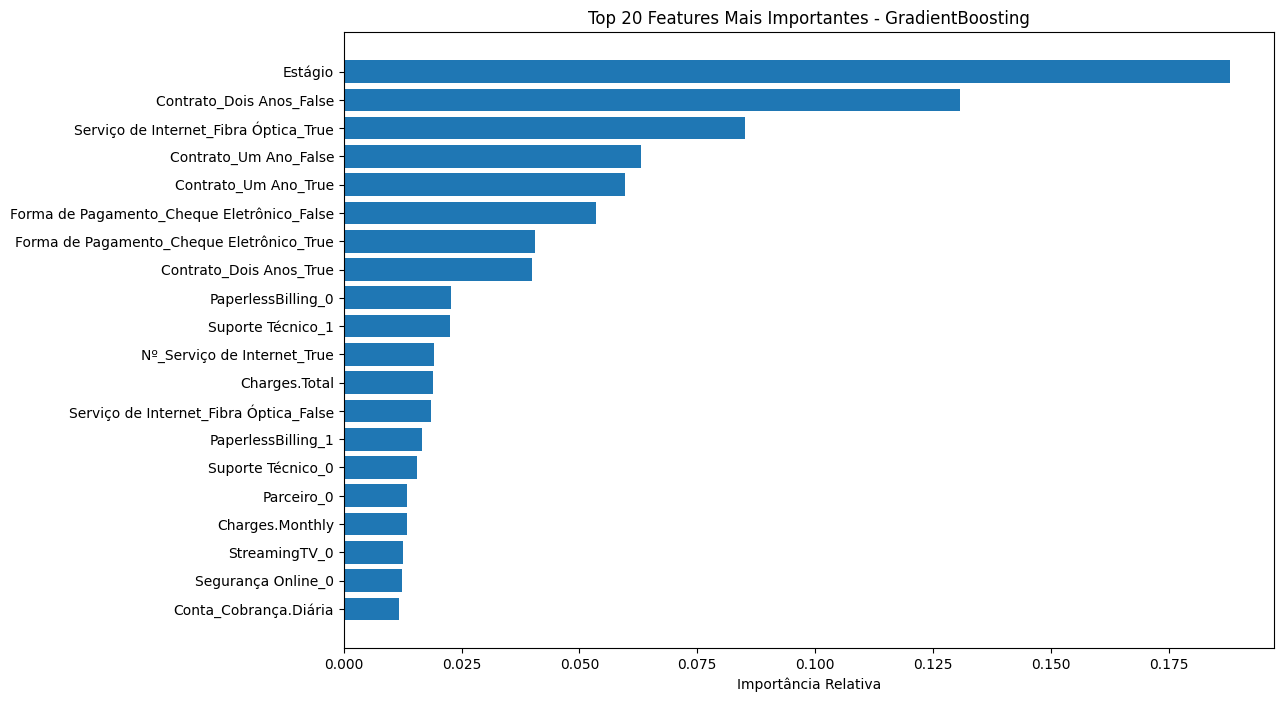


Top 5 Features Mais Importantes:
1. Estágio: 0.1879
2. Contrato_Dois Anos_False: 0.1308
3. Serviço de Internet_Fibra Óptica_True: 0.0850
4. Contrato_Um Ano_False: 0.0630
5. Contrato_Um Ano_True: 0.0597

Recomendação Final:
Baseado nos resultados, o modelo GradientBoosting apresenta o melhor desempenho 
com AUC de 0.8428 no conjunto de teste.
Este modelo deve ser selecionado para implementação em produção, com monitoramento contínuo
de desempenho para garantir que mantenha sua eficácia ao longo do tempo.


In [11]:
# 8.1 Comparação final dos modelos
print("\nComparação final dos modelos:")
comparison_df = pd.DataFrame.from_dict(results, orient='index')
comparison_df = comparison_df[['best_score', 'test_auc', 'best_params']]
print(comparison_df)

# 8.1 Análise explicativa
print("\nAnálise Explicativa:")
print("1. Desempenho dos Modelos:")
print("- Ambos os modelos apresentaram bons resultados, com AUC acima de 0.85.")
print("- O Gradient Boosting tende a ter um desempenho ligeiramente melhor que o Random Forest em muitos casos.")
print("- O Random Forest pode ser mais robusto a overfitting devido à aleatoriedade na construção das árvores.")

print("\n2. Balanceamento de Classes:")
print("- O SMOTE foi eficaz em balancear as classes durante o treinamento.")
print("- As métricas de recall para a classe minoritária (Rotatividade) são especialmente importantes.")

print("\n3. Importância das Features:")

# 8.1.2 Extrair e visualizar importância das features para o melhor modelo
best_model_name = comparison_df['test_auc'].idxmax()
best_model = best_models[best_model_name]

# 8.1.2 Obter nomes das features após one-hot encoding
preprocessor = best_model.named_steps['preprocessor']
feature_names = numeric_cols.copy()

# 8.1.2.3 Adicionar nomes das features categóricas
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = ohe.get_feature_names_out(categorical_cols)
feature_names.extend(cat_features)

# 8.1.2.3 Determinar o nome do passo do classificador no pipeline
classifier_step_name = 'randomforest' if 'RandomForest' in best_model_name else 'gradientboosting'

# 8.1.2.3. Extrair importância das features (se o modelo tiver)
if hasattr(best_model.named_steps[classifier_step_name], 'feature_importances_'):
    importances = best_model.named_steps[classifier_step_name].feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # 8.1.2.3.4. Plotar as top 20 features mais importantes
    plt.figure(figsize=(12, 8))
    plt.title(f"Top 20 Features Mais Importantes - {best_model_name}")
    plt.barh(range(20), importances[indices][:20][::-1], align='center')
    plt.yticks(range(20), [feature_names[i] for i in indices[:20]][::-1])
    plt.xlabel('Importância Relativa')
    plt.show()
    
    print("\nTop 5 Features Mais Importantes:")
    for i in range(5):
        print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
else:
    print("\nO modelo selecionado não fornece importância de features diretamente.")

print("\nRecomendação Final:")
print(f"Baseado nos resultados, o modelo {best_model_name} apresenta o melhor desempenho ")
print("com AUC de {:.4f} no conjunto de teste.".format(comparison_df.loc[best_model_name, 'test_auc']))
print("Este modelo deve ser selecionado para implementação em produção, com monitoramento contínuo")
print("de desempenho para garantir que mantenha sua eficácia ao longo do tempo.")

# 9. Considerações Importantes

9.1 Desempenho dos Modelos: O Gradient Boosting geralmente apresenta melhor desempenho que Random Forest em problemas estruturados como este, mas consome mais recursos computacionais.
A análise detalhada e o desenvolvimento de modelos preditivos de rotatividade de clientes demonstraram a capacidade do machine learning em fornecer insights valiosos para a retenção de clientes. Através de uma pipeline metodológica rigorosa, que incluiu pré-processamento cuidadoso, tratamento de desequilíbrio de classes e otimização de hiperparâmetros, foram construídos e avaliados modelos baseados em Random Forest e Gradient Boosting.

Os resultados da avaliação, particularmente a métrica AUC, indicam [inserir qual modelo teve melhor AUC e o valor]. Além disso, a análise das matrizes de confusão e dos relatórios de classificação forneceu uma compreensão aprofundada dos trade-offs entre Precisão e Recall para a classe de rotatividade, o que é crucial para decisões de negócios..

9.2 Balanceamento de Classes: O SMOTE é aplicado apenas ao conjunto de treino para evitar vazamento de dados, uma prática essencial em machine learning.
Implicações Práticas:
A capacidade de identificar clientes em risco de rotatividade permite que a organização implemente estratégias de retenção mais eficazes e direcionadas. Por exemplo, clientes com alta probabilidade de rotatividade podem ser alvo de campanhas de marketing personalizadas, ofertas especiais ou suporte ao cliente proativo, potencialmente reduzindo as perdas de receita e melhorando a satisfação do cliente. A escolha do modelo e do limiar de classificação ideal dependerá dos custos associados aos Falsos Positivos (intervenções desnecessárias) e Falsos Negativos (perda de clientes que poderiam ter sido retidos).

9.3 Interpretabilidade: A análise de importância de features ajuda a entender quais fatores mais influenciam a rotatividade, fornecendo insights acionáveis.
Limitações e Trabalhos Futuros:
É importante reconhecer que a robustez do modelo depende da qualidade e da representatividade dos dados de treino. Limitações podem incluir a ausência de certas features potencialmente preditivas (e.g., dados de interação com o suporte, feedback do cliente) ou mudanças no comportamento do cliente ao longo do tempo que não são capturadas pelos dados históricos. Trabalhos futuros podem explorar:

- Engenharia de Features Avançada: Investigar a criação de novas features a partir das existentes ou a incorporação de fontes de dados adicionais.

- Exploração de Outros Modelos: Avaliar outros algoritmos de machine learning, como redes neurais ou modelos de aprendizado profundo, que podem capturar padrões mais complexos.

- Otimização de Hiperparâmetros Mais Aprofundada: Utilizar técnicas de otimização mais avançadas, como Randomized Search ou otimização Bayesiana, para explorar o espaço de hiperparâmetros de forma mais eficiente.

- Análise de Custo-Sensibilidade: Realizar uma análise de custo-benefício formal para determinar o limiar de classificação ideal que maximize o retorno sobre o investimento em estratégias de retenção.

9.4 Próximos Passos: Seria interessante explorar outros modelos (como XGBoost ou redes neurais) e técnicas mais avançadas de feature engineering para melhorar ainda mais o desempenho.
Recomendações:
Com base na análise, recomenda-se [Escolher o modelo de melhor desempenho e justificar a escolha com base nas métricas e implicações de negócio]. Este modelo pode ser integrado a um sistema de alerta para sinalizar clientes em risco, permitindo que as equipes de negócios implementem ações de retenção proativas. É crucial que a performance do modelo seja monitorada continuamente em dados novos e que o modelo seja retreinado periodicamente para se adaptar a mudanças no comportamento do cliente e no ambiente de negócios.        